<font size = 6> Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pck
import sys 
import os
import importlib.util

spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec_win)
os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
sys.path.append(os.path.dirname('C:/Users/andre/Documents/UFCG/Photonics/Arquivos/Sensor de temperatura'))
spec_win.loader.exec_module(lumapi)


In [2]:
sensor = lumapi.MODE(filename = 'temperature_sensor.lms')
#sensor = lumapi.FDTD(filename = 'temp_sensor.fsp')

<font size = 6>Component assembly

In [3]:
# Initial Parameters
W = 500e-9
Gap = 200e-9
height = 250e-9
radius = 4e-6
accuracy = 5
freq_points = 100

sensor.switchtolayout()
sensor.selectall()
sensor.delete()

# Add substrate

sensor.addrect()
sensor.set({
    'name'          : 'substrate',
    'x'             : 20e-6,
    'x span'        : 40e-6,
    'y'             : 10e-6,
    'y span'        : 20e-6,
    'z'             : -1e-6,
    'z span'        : 2e-6,
    'material'      : 'SiO2 (Glass) - Palik'
})

# Ring resonator

sensor.addobject('ring_resonator')
sensor.set({
    'name'          : 'Ring',
    'material'      : 'Silicon_dT',
    'x'             : 10e-6,
    'y'             : 10e-6,
    'z'             : 0.125e-6,
    'lc'            : 0,
    'Gap'           : Gap,
    'radius'        : radius,
    'base width'    : W,
    'base height'   : height,
    'x span'        : 20e-6
})
sensor.setnamed('Ring::outer_bottom', {
    'enabled'       : False
})
# sensor.setnamed('Ring::arc2', {
#     'enabled'       : False
# })
# sensor.setnamed('Ring::arc3', {
#     'enabled'       : False
# })
# sensor.addrect()
# sensor.set({
#     'name'          : 'arm1',
#     'x'             : 16e-6,
#     'x span'        : W,
#     'y min'         : 8e-6,
#     'y max'         : 10e-6,
#     'z'             : 0.125e-6,
#     'z span'        : height,
#     'material'      : 'Silicon_dT'
# })
# sensor.addrect()
# sensor.set({
#     'name'          : 'arm2',
#     'x'             : 24e-6,
#     'x span'        : W,
#     'y min'         : 8e-6,
#     'y max'         : 10e-6,
#     'z'             : 0.125e-6,
#     'z span'        : height,
#     'material'      : 'Silicon_dT'
# })
# Slab

sensor.addrect()
sensor.set({
    'name'          : 'Slab',
    'x'             : 20e-6,
    'x span'        : 40e-6,
    'y'             : 10e-6,
    'y span'        : 20e-6,
    'z min'         : 0,
    'z max'         : 50e-9,
    'material'      : 'Silicon_dT'
})

# Simulation area

sensor.addvarfdtd()
sensor.set({
    'x'                         : 20e-6,
    'x span'                    : 15e-6,
    'y min'                     : 4.5e-6,
    'y max'                     : 17e-6,
    'z'                         : 0.125e-6,
    'z span'                    : 1e-6,
    'x0'                        : 0,
    'y0'                        : 3.95e-6,
})

test_points = np.array([[5e-6, 3.95e-6], [0, -4.75e-6], [0, -0.75e-6], [-5.5e-6, 3.95e-6]])

sensor.setnamed('varFDTD', {
    'simulation time'           : 10000e-15,
    'simulation temperature'    : 300,
    'test points'               : test_points,
    'mesh accuracy'             : accuracy,
    'set simulation bandwidth'  : True,
    'simulation wavelength min' : 1530e-9,
    'simulation wavelength max' : 1570e-9
    })

# Mode source and monitors

sensor.addmodesource()
sensor.set({
    'name'                      : 'input',
    'x'                         : 14e-6,
    'y'                         : 14.7e-6,
    'y span'                    : 3e-6,
    'wavelength start'          : 1530e-9,
    'wavelength stop'           : 1570e-9
})

sensor.addpower()
sensor.set({
    'name'                              : 'output',
    'monitor type'                      : 'Linear Y',
    'override global monitor settings'  : True,
    'frequency points'                  : freq_points,
    'x'                                 : 26e-6,
    'y'                                 : 10e-6 + radius + W + Gap,
    'y span'                            : 3e-6,
    'z'                                 : 0.125e-6
})

sensor.addprofile()
sensor.set({
    'name'                              : 'profile',
    'override global monitor settings'  : True,
    'frequency points'                  : freq_points,
    'x'                                 : 20e-6,
    'x span'                            : 15e-6,
    'y min'                             : 4.5e-6,
    'y max'                             : 17e-6,
    'z'                                 : 0.125e-6
})
sensor.addmesh()
sensor.set({
    'x'                                 : 20e-6,
    'x span'                            : 4.5e-6,
    'y min'                             : 13.5e-6,
    'y max'                             : 15.2e-6,
    'z'                                 : 0.125e-6,
    'z span'                            : 0.5e-6,
    'set equivalent index'              : True,
    'equivalent x index'                : 2,
    'equivalent y index'                : 2,
    'equivalent z index'                : 2
})

<font size = 6> Coupling x gap sweep

In [6]:
#gaps = [200e-9, 250e-9, 300e-9, 350e-9, 400e-9, 450e-9, 500e-9, 550e-9, 600e-9]
gaps = [200e-9, 250e-9, 300e-9, 350e-9]

data = np.zeros([len(gaps),3])

for i, gap in enumerate(gaps):

    sensor.switchtolayout()

    print('running {}/{}'.format(i+1, len(gaps)))

    test_points = np.array([[5e-6, 3.95e-6 + (50e-9)*i], [0, -4.75e-6], [0, -0.75e-6], [-5.5e-6, 3.95e-6 + (50e-9)*i]])

    sensor.setnamed('Ring', {
        'gap'               : gap,
    })
    sensor.setnamed('varFDTD', {
        'y0'                : 3.95e-6 + (50e-9)*i,
        'test points'       : test_points
    })
    sensor.setnamed('input',{
        'y'                 : 14.7e-6 + (50e-9)*i,
    })
    sensor.setnamed('output',{
        'y'                 : 14.7e-6 + (50e-9)*i,
    })
    sensor.setnamed('mesh', {
        'y max'             : 15.2e-6 + (50e-9)*i,
    })
#     sensor.run()

#     output = sensor.getresult('output', 'T')
#     r = output['T']
#     r = abs(r**2)
#     k = abs(1-r)

#     data[i] = [gap*1e9, max(k), min(r)]

# # Saving data into txt
# with open('SavedData/Gap_Sweep' + '.txt', 'wb') as file:
#     pck.dump(data,file)
# file.close()

running 1/4
running 2/4
running 3/4
running 4/4


In [9]:
with open('SavedData/Gap_Sweep' +'.txt', 'rb') as file: # Read .txt file
     data = pck.load(file)
file.close()

# showing data 
gapsweep = pd.DataFrame(data, columns=['gap (nm)', 'k^2', 'r^2']) 
display(gapsweep)

,gap (nm),k^2,r^2
0,200.0,0.163079,0.836921
1,250.0,0.065477,0.934523
2,300.0,0.027527,0.972473
3,350.0,0.010128,0.989872
4,400.0,0.003522,0.996478
5,450.0,0.001467,0.998533
6,500.0,0.001274,1.000502
7,550.0,0.000831,1.000141
8,600.0,0.001144,1.000656


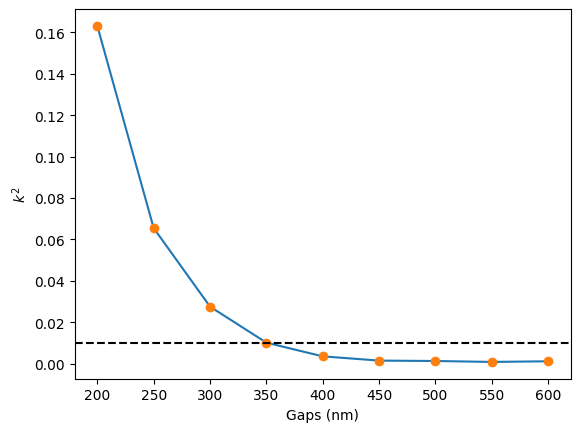

In [45]:
x_axis = np.zeros(len(gaps))
y_axis = np.zeros(len(gaps))

for i in range(len(gaps)):
    x_axis[i] = data[i][0]
    y_axis[i] = data[i][1]

plt.plot(x_axis, y_axis)
plt.plot(x_axis, y_axis, 'o')
plt.xlabel('Gaps (nm)', fontsize = 10)
plt.ylabel(r'$k^2$', fontsize = 10)
plt.axhline(0.01, ls = '--', color = 'k')

<font size = 6> Simulation

In [4]:
sensor.switchtolayout()

test_points = np.array([[5e-6, 4.1e-6], [0, -4.75e-6], [0, -0.75e-6], [-5.5e-6, 4.1e-6]])

sensor.setnamed('Ring', {
    'gap'           : 350e-9
})
sensor.setnamed('varFDTD', {
    'y0'                : 4.1e-6,
    'test points'       : test_points,
    'mesh accuracy'     : 4
})

sensor.setnamed('input',{
    'y'                 : 14.85e-6,
})
sensor.setnamed('output',{
    'y'                 : 14.85e-6,
})
sensor.setnamed('mesh', {
    'y max'             : 15.35e-6,
})

In [8]:
sensor.run()

<font size = 6> Field profile

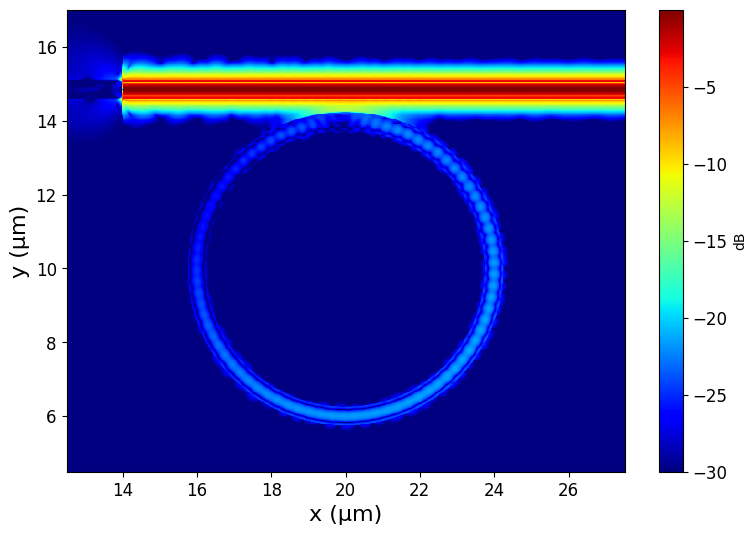

In [9]:
field_profile = sensor.getresult('profile', 'E')
x = field_profile['x']
y = field_profile['y']
E = field_profile['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))

Elog = 10*np.log10(E)
plt.rcParams["figure.figsize"] = (9,6)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet',vmin=-30)
plt.xlabel('x (μm)',fontsize=16)
plt.ylabel('y (μm)',fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.savefig('Imagens/E Log.png')

<font size = 6>Transmission

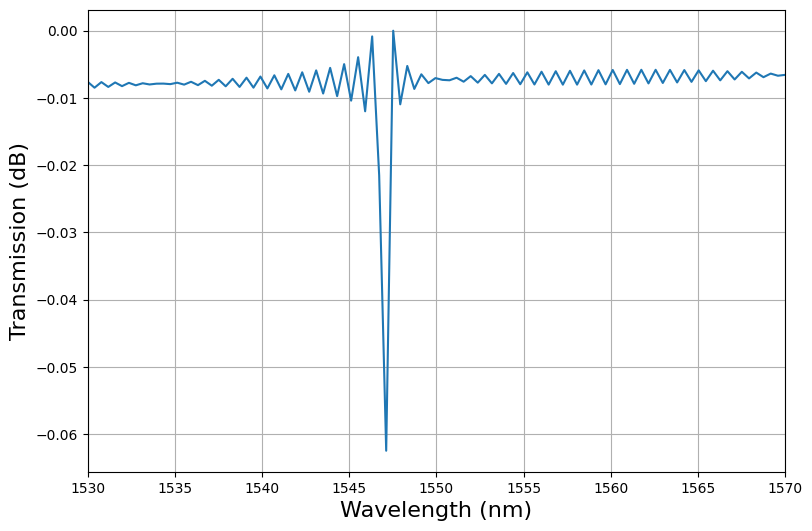

In [11]:
output = sensor.getresult('output', 'T')
wavelength = output['lambda']
T = output['T']

T = abs(T**2)

plt.figure(figsize = (9,6))
plt.plot(wavelength*1e9, 10*np.log10(T/T.max()))
plt.xlim(1530, 1570)
#plt.ylim(-10, 0)
plt.xlabel('Wavelength (nm)', fontsize = 16)
plt.ylabel('Transmission (dB)', fontsize = 16)
plt.grid(True)
plt.savefig('Imagens/Transmisson.png')

<font size = 6>Temperature Sweep

In [5]:
temperatures = [288.15, 293.15, 298.15, 303.15, 308.15, 313.15, 318.15]

results = np.zeros([len(temperatures), freq_points])

for i, temperature in enumerate(temperatures):
    sensor.switchtolayout()

    print('running {}/7'.format(i+1))

    sensor.setnamed('varFDTD', {
        'simulation temperature'    : temperature,
        'mesh accuracy'             : 4
    })

    sensor.run()

    output = sensor.getresult('output', 'T')
    transmission = output['T']
    transmission = abs(transmission**2)
    wavelength = output['lambda']

    results[:][i] = 10*np.log10(transmission/transmission.max())

    print('completed {}/7'.format(i+1))


running 1/7
completed 1/7
running 2/7
completed 2/7
running 3/7
completed 3/7
running 4/7
completed 4/7
running 5/7
completed 5/7
running 6/7
completed 6/7
running 7/7
completed 7/7


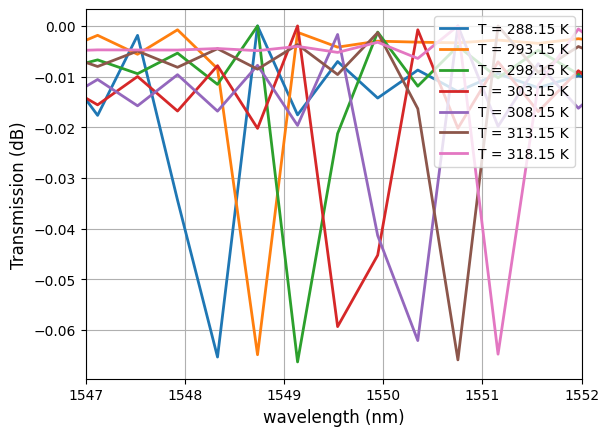

In [8]:
for i in range(len(temperatures)):    
    plt.plot(wavelength*1e9, results[:][i], label = 'T = {} K'.format(temperatures[i]), linewidth = 2)

plt.legend(loc = 'upper right', fontsize = 10)
plt.xlim(1547, 1552)
plt.xlabel('wavelength (nm)', fontsize = 12)
plt.ylabel('Transmission (dB)', fontsize = 12)
plt.grid(True)
plt.savefig('Imagens/Temp_sweep.png')

<font size = 6>FDTD

In [19]:
# Initial Parameters
W = 500e-9
Gap = 350e-9
height = 250e-9
radius = 4e-6
accuracy = 3
freq_points = 100

sensor.switchtolayout()
sensor.selectall()
sensor.delete()

# Add substrate

sensor.addrect()
sensor.set({
    'name'          : 'substrate',
    'x'             : 20e-6,
    'x span'        : 40e-6,
    'y'             : 10e-6,
    'y span'        : 20e-6,
    'z'             : -1e-6,
    'z span'        : 2e-6,
    'material'      : 'SiO2 (Glass) - Palik'
})

# Ring resonator

sensor.addobject('ring_resonator')
sensor.set({
    'name'          : 'Ring',
    'material'      : 'Silicon_dT',
    'x'             : 10e-6,
    'y'             : 10e-6,
    'z'             : 0.125e-6,
    'lc'            : 0,
    'Gap'           : Gap,
    'radius'        : radius,
    'base width'    : W,
    'base height'   : height,
    'x span'        : 20e-6
})
sensor.setnamed('Ring::outer_bottom', {
    'enabled'       : False
})

# Slab

sensor.addrect()
sensor.set({
    'name'          : 'Slab',
    'x'             : 20e-6,
    'x span'        : 40e-6,
    'y'             : 10e-6,
    'y span'        : 20e-6,
    'z min'         : 0,
    'z max'         : 50e-9,
    'material'      : 'Silicon_dT'
})

# Simulation area

sensor.addfdtd()
sensor.set({
    'x'                         : 20e-6,
    'x span'                    : 15e-6,
    'y min'                     : 4.5e-6,
    'y max'                     : 17e-6,
    'z'                         : 0.125e-6,
    'z span'                    : 1e-6,
    'simulation time'           : 10000e-15,
    'simulation temperature'    : 300,
    'mesh accuracy'             : accuracy,
    'set simulation bandwidth'  : True,
    'simulation wavelength min' : 1530e-9,
    'simulation wavelength max' : 1570e-9
})

# Mode source and monitors
sensor.addport()
sensor.set({
    'x'                         : 14e-6,
    'y'                         : 14.85e-6,
    'y span'                    : 3e-6,
})
sensor.addport()
sensor.set({
    'x'                                 : 26e-6,
    'y'                                 : 14.85e-6,
    'y span'                            : 3e-6,
    'direction'                         : 'Backward',
})
sensor.addmesh()
sensor.set({
    'x'                                 : 20e-6,
    'x span'                            : 4.5e-6,
    'y min'                             : 13.5e-6,
    'y max'                             : 15.35e-6,
    'z'                                 : 0.125e-6,
    'z span'                            : 0.5e-6,
    'set equivalent index'              : True,
    'equivalent x index'                : 2,
    'equivalent y index'                : 2,
    'equivalent z index'                : 2
})


<font size = 6>Interconnect

In [21]:
sensor.deletesweep('s-parameter sweep')
sensor.addsweep(3)
sensor.runsweep()